<a href="https://colab.research.google.com/github/dolmani38/nash_loss/blob/master/Global%20optimization%20experiment%20of%20game%20theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 게임이론 최적화 알고리즘 

import random
import numpy as np
import time

class Based_on_play_theory_optimizer():

    def __make_strategy(self, number_of_player=10,strategy_range=[-20,20],number_of_strategy=20,resolution=1):
        """
        주어진 player의 수, strategy의 영역, strategy의 개수에 의해 
        전체 pure strategy와 mixed strategy를 생성한다.
        [[[pure,mixed]... ~ number_of_strategy]... ~ number_of_player ]
        .shape = (number_of_player,number_of_strategy,2 (pure,mixed))
        """        
        def non_duplicate_randrange(l,h,r,c):
            #lst = np.asarray([[random.randrange(l*1/r,h*1/r) * r,1/c] for i in range(c)])
            #while (not len(lst[:,0]) == len(set(lst[:,0]))):
            #    lst = np.asarray([[random.randrange(l*1/r,h*1/r) * r,1/c] for i in range(c)])
            #return lst    
            t = np.ones((c,2))
            x = np.linspace(l, h, c)
            t[:,0] = x[:]
            t[:,1] = 1/c    
            return t    

        S = [non_duplicate_randrange(strategy_range[0],strategy_range[1],resolution,number_of_strategy) for x in range(number_of_player)]
        return np.asarray(S, dtype=np.float64)

    def __choice_strategies(self, strategy_matrix):
        """
        S에서 player들에 대한 전략을 선택 한다.
        선택은 mixed strategy의 확율에 의해..
        """
        return [random.choices(population=strategy_matrix[i,:,0],weights=strategy_matrix[i,:,1],k=1)[0] for i in range(strategy_matrix.shape[0])]
    
    def __make_Y_sample(self, strategy_matrix,player=0,p_strategy=0,sample_count = 10):
        """
        player 0의 pure strategy에 대한 (si,Y-i(t)) 생성, 표본 개수 10개
        """
        Y_sample =np.array([self.__choice_strategies(strategy_matrix) for i in range(sample_count)])
        Y_sample[:,player] = strategy_matrix[player,p_strategy,0]
        return Y_sample

    def __obj_func(self,syn0,l0,y):
        def nonlin(x):
            return 1/(1+np.exp(-x))
        syn0 = np.array(syn0)
        syn0 = syn0.reshape(syn0.shape[0],1)
        #l0 = X
        l1 = nonlin(np.dot(l0,syn0))

        # how much did we miss?
        l1_error = y - l1
        return np.sum(np.abs(l1_error))

    def __u_si_Y_i(self,x,y,sample_strategies = None):
        """
        (si,Y-i(t))에서 playe 0의 각 pure_strategy에 대한 sample의 f1 평균값 계산 
        """
        y_m = np.asarray([np.mean([self.__obj_func(sample_strategies[j,i,:],x,y) for i in range(sample_strategies.shape[1])]) for j in range(sample_strategies.shape[0])])
        return y_m

    def optimize(self,
                 #object_function=None,
                 X = None,
                 Y = None,
                 batch_size = 10,
                 #player_count=10,
                 strategy_range=[-20,20],
                 number_of_strategies = 20,
                 sample_count = 10,
                 epoch = 100,
                 verbose=1,
                 resolution=1):
        
        player_count = X.shape[1]
        strategy_matrix = self.__make_strategy(player_count,strategy_range,number_of_strategies,resolution)
        history = []
        for t in range(1,epoch+1):
            start_time = time.time()
            #Sample strategy 추출
            si_Y_i = np.asarray([[self.__make_Y_sample(strategy_matrix,player=j,p_strategy=i,sample_count = sample_count) for i in range(strategy_matrix.shape[1])] for j in range(strategy_matrix.shape[0])])
            #print("1. elapsed_time:",time.time() - start_time )
            #batch_size = 10
            for p in range(0,X.shape[0],batch_size):
                x = X[p:p + batch_size]
                y = Y[p:p + batch_size]
                if x.shape[0] >= batch_size:
                    #print(x.shape)
                    #print(y.shape)
                    #시행에 대한 best response 추출
                    br = np.asarray([strategy_matrix[i,self.__u_si_Y_i(x,y,sample_strategies = si_Y_i[i,:,:,:]).argmin(),0] for i in range(strategy_matrix.shape[0])])
                    #print("2. elapsed_time:",time.time() - start_time )
                    #mixed strategy의 갱신
                    for i in range(strategy_matrix.shape[0]):
                        strategy_matrix[i,:,1] = strategy_matrix[i,:,1]+(1/(t+1))*(((strategy_matrix[i,:,0]==br[i]) * 1) - strategy_matrix[i,:,1])
                    #print("3. elapsed_time:",time.time() - start_time )
            #다음 strategy 추출
            s = self.__choice_strategies(strategy_matrix)
            #print("4. elapsed_time:",time.time() - start_time )
            # 목적함수의 값 산출
            mv = self.__obj_func(s,X,Y)
            #print("5. elapsed_time:",time.time() - start_time )

            print("{}/{} object_function({})={}               ".format(t,epoch,s,mv))
            history.append(mv)
        return strategy_matrix,history,s 


In [71]:
def __make_strategy(number_of_player=10,strategy_range=[-20,20],number_of_strategy=20,resolution=1):
    """
    주어진 player의 수, strategy의 영역, strategy의 개수에 의해 
    전체 pure strategy와 mixed strategy를 생성한다.
    [[[pure,mixed]... ~ number_of_strategy]... ~ number_of_player ]
    .shape = (number_of_player,number_of_strategy,2 (pure,mixed))
    """
    def non_duplicate_randrange(l,h,r,c):
        #lst = np.asarray([[random.randrange(l*1/r,h*1/r) * r,1/c] for i in range(c)])
        #while (not len(lst[:,0]) == len(set(lst[:,0]))):
        #    lst = np.asarray([[random.randrange(l*1/r,h*1/r) * r,1/c] for i in range(c)])
        #return lst    
        t = np.ones((c,2))
        x = np.linspace(l, h, c)
        t[:,0] = x[:]
        t[:,1] = 1/c    
        return t    

    S = [non_duplicate_randrange(strategy_range[0],strategy_range[1],resolution,number_of_strategy) for x in range(number_of_player)]
    return np.asarray(S, dtype=np.float64)


def __choice_strategies(strategy_matrix):
    """
    S에서 player들에 대한 전략을 선택 한다.
    선택은 mixed strategy의 확율에 의해..
    """
    return [random.choices(population=strategy_matrix[i,:,0],weights=strategy_matrix[i,:,1],k=1)[0] for i in range(strategy_matrix.shape[0])]

def __make_Y_sample(strategy_matrix,player=0,p_strategy=0,sample_count = 10):
    """
    player 0의 pure strategy에 대한 (si,Y-i(t)) 생성, 표본 개수 10개
    """
    Y_sample = np.array([__choice_strategies(strategy_matrix) for i in range(sample_count)])
    Y_sample[:,player] = strategy_matrix[player,p_strategy,0]
    return Y_sample

S = __make_strategy(number_of_player=5,strategy_range=[-10,10],number_of_strategy=10)
M = __make_Y_sample(S,0,1)
M

array([[ -7.77777778,  10.        ,  -7.77777778,   1.11111111,
          7.77777778],
       [ -7.77777778,   3.33333333,   3.33333333,  -7.77777778,
          5.55555556],
       [ -7.77777778, -10.        ,  -1.11111111,   5.55555556,
        -10.        ],
       [ -7.77777778,  -5.55555556,   7.77777778,   3.33333333,
          3.33333333],
       [ -7.77777778,   3.33333333,  -1.11111111,  -3.33333333,
         -5.55555556],
       [ -7.77777778, -10.        ,  10.        ,  -3.33333333,
          5.55555556],
       [ -7.77777778,   1.11111111,  -3.33333333,  -3.33333333,
          1.11111111],
       [ -7.77777778,  10.        ,  10.        ,   5.55555556,
          3.33333333],
       [ -7.77777778,  -5.55555556,   7.77777778,  -5.55555556,
         -5.55555556],
       [ -7.77777778,   1.11111111,   5.55555556,  -1.11111111,
         -3.33333333]])

1. elapsed_time: 0.15726542472839355
1/100 object_function([-17.894736842105264, 1.0526315789473664, -20.0, -17.894736842105264, -20.0, 15.789473684210527, -20.0, 1.0526315789473664, -20.0, -20.0])=-118.96447557660736               1. elapsed_time: 0.15721392631530762
2/100 object_function([-15.789473684210527, 3.1578947368421026, -20.0, -5.2631578947368425, -15.789473684210527, -15.789473684210527, -20.0, 5.2631578947368425, -20.0, -20.0])=-115.81183973167506               1. elapsed_time: 0.15142202377319336
3/100 object_function([-15.789473684210527, -20.0, 1.0526315789473664, -13.68421052631579, -1.05263157894737, -20.0, -20.0, 5.2631578947368425, -17.894736842105264, -5.2631578947368425])=-93.04541405885418               1. elapsed_time: 0.1575605869293213
4/100 object_function([-17.894736842105264, -20.0, -20.0, -20.0, -1.05263157894737, 17.89473684210526, -20.0, -9.473684210526317, -17.894736842105264, -15.789473684210527])=-103.72676561562388               1. elapsed_time: 0.16

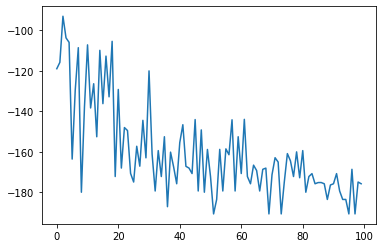

In [73]:
# 실험1
import matplotlib.pyplot as plt
# 논문에서 f1에 해당하는 함수
def f1(player_strategies):
    y = - np.sum(player_strategies* np.sin(np.lib.scimath.sqrt(np.abs(player_strategies))))
    return y

play_optimizer = Based_on_play_theory_optimizer()

S,history,op = play_optimizer.optimize(object_function=f1,player_count=10,strategy_range=[-20,20],number_of_strategies=20,sample_count=10,epoch=100,resolution=1)

plt.plot(history)
plt.show()


In [0]:
# 간단한 신경망
# input 3개 node, output 1개 node
# dataset
# 0,0,1 - 0
# 0,1,1 - 0
# 1,0,1 - 1
# 1,1,1 - 1

import numpy as np

# sigmoid function
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))
    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,0,1,1]]).T

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly with mean 0 
#
syn0 = (2*np.random.random((3,1))-1) * 10
print("Initial weights:",syn0)
for iter in range(10000):

    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1

    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)

    # update weights
    syn0 += np.dot(l0.T,l1_delta)

print ("Output After Training:",l1)
print("Weights After Training:",syn0)

Initial weights: [[-1.65955991]
 [ 4.40648987]
 [-9.9977125 ]]
Output After Training: [[0.00254887]
 [0.00750238]
 [0.99270225]
 [0.99752098]]
Weights After Training: [[10.88247479]
 [ 1.08449735]
 [-5.96955506]]


100/100 object_function([ 95.95959596  -1.01010101 -41.41414141])=1.4090917978116712e-18               

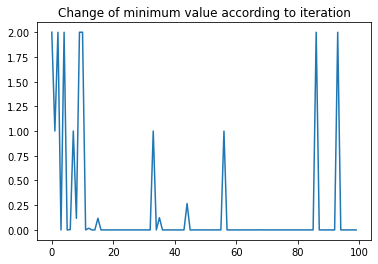

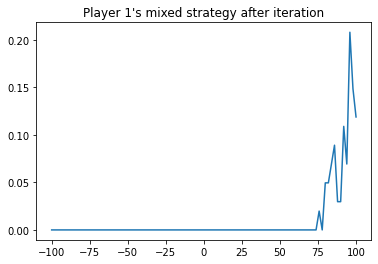

Output After Training: [1.03292053e-18 3.76171264e-19 1.00000000e+00 1.00000000e+00]
Weights After Training: [ 95.95959596  -1.01010101 -41.41414141]


In [0]:
# 게임이론 최적화 알고리즘 에 의한 신경망 test
import matplotlib.pyplot as plt
import numpy as np

# sigmoid function
def nonlin(x):
    return 1/(1+np.exp(-x))
    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,0,1,1]]).T

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

def f(syn0):
      # forward propagation
    syn0 = np.array(syn0)
    syn0 = syn0.reshape(syn0.shape[0],1)
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1
    return np.sum(np.abs(l1_error))

play_optimizer = Based_on_play_theory_optimizer()

S,history,op = play_optimizer.optimize(object_function=f,player_count=3,strategy_range=[-100,100],number_of_strategies=100,sample_count=10,epoch=100,resolution=1)

plt.plot(history)
plt.title("Change of minimum value according to iteration")
plt.show()

plt.plot(S[0,:,0].reshape(S.shape[1]),S[0,:,1].reshape(S.shape[1]))
plt.title("Player 1's mixed strategy after iteration")
plt.show()    


print("Output After Training:",nonlin(np.dot(l0,op)))
print("Weights After Training:",op)

In [116]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")  #loadtxt('pima-indians-diabetes.csv', delimiter=',')
#dataset = dataset.loc[0:10]
# split into input (X) and output (y) variables
print(dataset.shape)
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]
# define the keras model
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=200, batch_size=5,verbose=0)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
#print('yy:',yy)

(767, 9)
767/767 [==============================] - 0s 41us/step
Accuracy: 74.19


In [0]:
# 간단한 신경망
# input 8개 node, output 1개 node
# dataset

import numpy as np
import pandas as pd
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")  #loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
print(dataset.shape)
X = np.asarray(dataset.iloc[:,0:8])
X = X/np.max(X)
print(X)
y = np.asarray(dataset.iloc[:,8]).reshape(1,len(X)).T
print(X.shape)
print(y.shape)

# sigmoid function
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly with mean 0 
#
syn0 = (2*np.random.random((8,1))-1) * 10
print("Initial weights:",syn0)
for iter in range(30000):

    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1

    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)

    # update weights
    syn0 += np.dot(l0.T,l1_delta)


print("Weights After Training:",syn0)
l1=l1.round()
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, l1)

print('Accuracy:',accuracy)

#print(l1)

(767, 9)
[[1.18203310e-03 1.00472813e-01 7.80141844e-02 ... 3.14420804e-02
  4.14893617e-04 3.66430260e-02]
 [9.45626478e-03 2.16312057e-01 7.56501182e-02 ... 2.75413712e-02
  7.94326241e-04 3.78250591e-02]
 [1.18203310e-03 1.05200946e-01 7.80141844e-02 ... 3.32151300e-02
  1.97399527e-04 2.48226950e-02]
 ...
 [5.91016548e-03 1.43026005e-01 8.51063830e-02 ... 3.09692671e-02
  2.89598109e-04 3.54609929e-02]
 [1.18203310e-03 1.48936170e-01 7.09219858e-02 ... 3.55791962e-02
  4.12529551e-04 5.55555556e-02]
 [1.18203310e-03 1.09929078e-01 8.27423168e-02 ... 3.59338061e-02
  3.72340426e-04 2.71867612e-02]]
(767, 8)
(767, 1)
Initial weights: [[-1.65955991]
 [ 4.40648987]
 [-9.9977125 ]
 [-3.95334855]
 [-7.06488218]
 [-8.1532281 ]
 [-6.27479577]
 [-3.08878546]]
Weights After Training: [[134.9597165 ]
 [ 14.60375033]
 [-29.44972474]
 [  0.69433896]
 [  0.60594095]
 [ -4.90083161]
 [ 36.9932127 ]
 [-19.03425915]]
Accuracy: 0.7014341590612777


(200, 9)
(200, 8)
(200, 1)
1/10 object_function([134.83709273182956, -98.7468671679198, -156.8922305764411, -41.60401002506268, 189.97493734335836, -171.9298245614035, 9.523809523809518, -73.6842105263158])=71.14906869658947               
2/10 object_function([98.74686716791979, 58.64661654135335, -42.60651629072683, -193.98496240601503, 172.93233082706763, -85.71428571428572, -58.64661654135338, -58.64661654135338])=89.44089212077573               
3/10 object_function([103.75939849624058, 37.59398496240601, -164.91228070175438, -152.88220551378447, 138.84711779448622, -30.57644110275689, -130.82706766917295, -133.83458646616543])=72.87193531660017               
4/10 object_function([-78.6967418546366, -188.97243107769424, -96.74185463659148, -105.76441102756893, 193.98496240601503, -137.84461152882204, -51.62907268170426, -198.99749373433585])=74.9103576134902               
5/10 object_function([-88.72180451127821, 100.7518796992481, -181.95488721804512, -131.8295739348371, -70.67

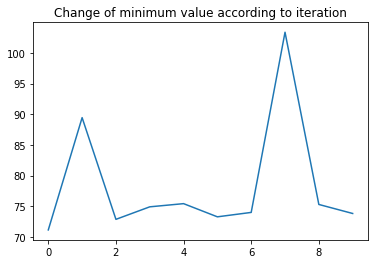

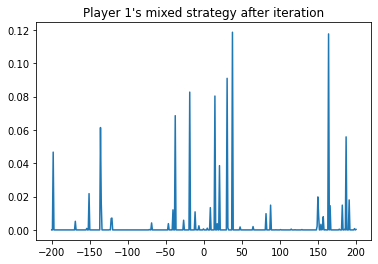

[[0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]]

In [168]:
# 게임이론 최적화 알고리즘 에 의한 신경망 test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# load the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")  #loadtxt('pima-indians-diabetes.csv', delimiter=',')
dataset = dataset.loc[0:10*20 - 1]
# split into input (X) and output (y) variables
print(dataset.shape)
X = np.asarray(dataset.iloc[:,0:8])
X = X/np.max(X)
#print(X)
Y = np.asarray(dataset.iloc[:,8]).reshape(1,len(X)).T
print(X.shape)
print(Y.shape)

# seed random numbers to make calculation
# deterministic (just a good practice)



play_optimizer = Based_on_play_theory_optimizer()

S,history,op = play_optimizer.optimize(X,Y,batch_size = 10,strategy_range=[-200,200],number_of_strategies=400,sample_count=5,epoch=10,resolution=1)

plt.plot(history)
plt.title("Change of minimum value according to iteration")
plt.show()

plt.plot(S[0,:,0].reshape(S.shape[1]),S[0,:,1].reshape(S.shape[1]))
plt.title("Player 1's mixed strategy after iteration")
plt.show() 

# sigmoid function
def nonlin(x):
    return 1/(1+np.exp(-x))

op = np.array(op)
op = op.reshape(op.shape[0],1)
l1 = nonlin(np.dot(X,op))
l1 = l1.round()
print(Y)
print(l1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y, l1)

print('Accuracy:',accuracy)

